## Apple Product Sentiment Analysis

### by Monica Pecha, Sam Choe, and Daniel Fox

### Overview

This project utilized Natural Language Processing (NLP) to understand the sentiment of Apple products from the 2011 SXSW conference in Austin, Texas. The objective was to build a model that can rate the sentiment of a tweet based on its text.

### Business Understanding

Our group was hired as a data advisory group for Apple. Apple is seeking to better understand product sentiment to inform business practices, e.g., how are products recieved, how are products launched, what product issues are notable, and overall product sentiment. 

### Data Understanding and Limitations
The dataset comes from CrowdFlower via data.world. The initial dataset contains three features (tweet text, product creator, and human derived sentiment) and 9093 rows regarding both Google and Apple products. 


Limitations include that tweets focused on Apple products in relation to the SXSW conference in 2011 and may not be generalizable across non conference participants over time. After VADER sentiment analysis was implemented spot checks indicated that there were several tweets that were not classified correctly. Additionally, the synthetic data generated from ChatGPT produced some words repeatedly, more than we might expect in real life, probably introducing inflated frequencies. 

### Table of Contents
- Exploratory Data Analysis
    - Synthesizing additional data
    - Feature Engineering
    - Implementing VADER
    - Frequencies and Distribution
    - Vectorization
- Preprocessing
    - Add stopwords, remove punctuation, lowercase all, remove numbers 
    - Tokenizing
    - Vectorizing
        - Count Vectorization
        - Term Frequency - Inverse Document Frequency (Tf-Idf) Vectorization
- Modeling and Evaluating
    - Multinomal Naive Bayes (MNB)
    - Random Forest Classifier (RFC)
    

### Exploratory Data Analysis (EDA)

In [276]:
# Bringing in packages for EDA, pre-processing, modeling, and visualizations

import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
import os

from collections import Counter
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [277]:
# Reading in the original dataset
df = pd.read_csv("data/judge-1377884607_tweet_product_company.csv", encoding="ISO-8859-1")

In [278]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


ABOVE, the initial data .info shows us that we're missing the specific product (e.g, Apple, Google) in almost two-thirds of tweets. We see later that the one missing tweet_text is related to a non-Apple product and therefore not in scope for our analysis so does not need special handling. 

In [280]:
df["emotion_in_tweet_is_directed_at"].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

ABOVE, the products feature is not standardized. Below we group products into Apple and non-Apple/Google and ultimately drop non-Apple products.

In [281]:
df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

ABOVE, the dataset starts with four sentiment/emotion categories. We regrouped the "No emotion..." and "I can't tell" into a single category. They are not equal, but we felt they were an appropriate combination.

In [282]:
# Enter differnt numbers after .iloc in [#] to spot check the text of tweets
df["tweet_text"].iloc[4]

"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"

In [283]:
# Defining keywords to diferentiate between Google and Apple product tweets
apple_keywords = ['iPad', 'IPad', 'iPAD', 'i-Pad', 'IPAD', 'iphone', 'iPhone', 'Iphone', 'i-phone', 'I-Phone', 'Apple', 'apple', 'Ipad', 'ipad', 'iTunes','Mac', 'IPhone', 'IPHONE']
google_keywords = ['google', 'android', 'Google', 'Android', 'samsung', 'GOOGLE', "#Android", '#android']

def find_brand(text):
    if isinstance(text, str):
        for word in apple_keywords:
            if word in text:
                return "Apple" 
        for word in google_keywords:
            if word in text:
                return "Google" 
    return 'No_Product'

df['product'] = df['tweet_text'].apply(find_brand)

In [284]:
# Reviewing new product category based on the definition created in the cell above
df['product'].value_counts()

Apple         5587
Google        2771
No_Product     735
Name: product, dtype: int64

In [285]:
# Looking for null values in 'product'
df['product'].isna().sum()

0

In [286]:
df['product'].head()

0     Apple
1     Apple
2     Apple
3     Apple
4    Google
Name: product, dtype: object

In [287]:
# Converting strings to integers and combining 'neutral'/'no emotion toward brand or product' with 'unknown'/'I can't tell'
# 0 = negative, 1 = neutral, and 2 = positive
# Renaming 'is_there_an_emotion_directed_at_a_brand_or_product' to 'emotion'
mapping = {"Positive emotion": 2, "No emotion toward brand or product": 1, "I can't tell": 1, "Negative emotion": 0}
df['emotion'] = df["is_there_an_emotion_directed_at_a_brand_or_product"].map(mapping)

In [288]:
# Reviewing new emotion category based on the definition created in the cell above
df["emotion"].value_counts()

1    5545
2    2978
0     570
Name: emotion, dtype: int64

In [289]:
# Use 1 to show all info in cell below then comment it out and use 2 to go back to default view

#1
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

#2
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

In [290]:
#exploring 'No_Product' tweets
filtered_df = df[df['product'] == 'No_Product']

print(filtered_df['tweet_text'])

6                                                     NaN
51      ÛÏ@mention {link} &lt;-- HELP ME FORWARD THIS...
52      ÷¼ WHAT? ÷_ {link} ã_ #edchat #musedchat #s...
53      .@mention @mention on the location-based 'fast...
65      Agree. RT @mention Wait. FIONA APPLE is in tow...
                              ...                        
8936    CLIENT NEWS! @mention Releases &quot;Dope Melo...
8958    iPAD / #SXSW PEOPLE: @mention brilliant Spider...
8970    This is my 5th year downloading the #sxsw Musi...
9024    by the way, we're looking for a spanish-speaki...
9026    True story! RT @mention I just rated Amy's Ice...
Name: tweet_text, Length: 735, dtype: object


In [291]:
# Dataframe with regrouped product and emotion categories
df2 = df[["tweet_text", "product", "emotion"]]

In [292]:
# Creating an Apple product only dataframe
df2_apple = df2[df2['product'] == "Apple"]

In [293]:
df2_apple.head()

,tweet_text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,2
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,2
3,@sxsw I hope this year's festival isn't as cra...,Apple,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,1


In [294]:
df2_apple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5587 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  5587 non-null   object
 1   product     5587 non-null   object
 2   emotion     5587 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 174.6+ KB


In [295]:
# The emotion in the dataset in not balanced
df2_apple["emotion"].value_counts(normalize=True)

1    0.540720
2    0.383748
0    0.075532
Name: emotion, dtype: float64

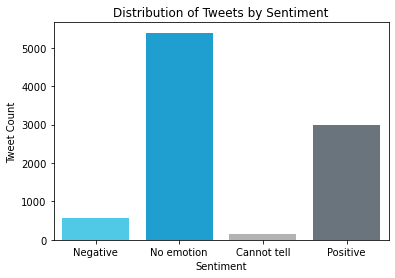

In [296]:
# Visualizing the imbalanced dataset --this is the entire initial dataset, not just Apple products
fig, ax = plt.subplots()

custom_palette = ['#36d8ff', '#00acee', '#b3b3b3', '#66757f']

classes = ['Negative emotion', 'No emotion toward brand or product', "I can't tell", 'Positive emotion']
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=df, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion', 'Cannot tell','Positive'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('images/fig0.png', dpi=200, transparent=True)
plt.show()

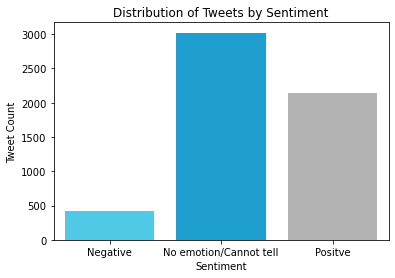

In [297]:
# Visualizing the imbalanced dataset --this is the initial dataset for Apple products only
fig, ax = plt.subplots()


classes = [0, 1, 2]
sns.countplot(x='emotion', data=df2_apple, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion/Cannot tell', 'Positve'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('images/fig1.png', dpi=200, transparent=True)
plt.show()

To address the "emotion" feature class inbalance we attempted to scrape down tweets from Twitter about Apple products with negative sentiment. The code for this process can be found in the Twitter_scraping_template notebook found in the GitHub repo Apple Product Sentiment Analysis. The scraping was unsuccessful due to access issues:

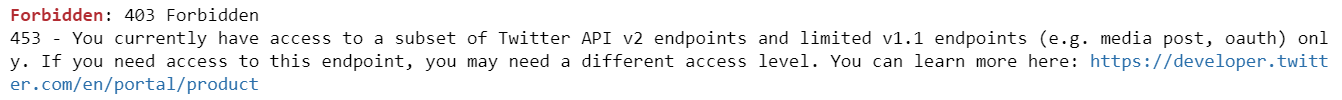

## This is where new EDA starts

In [417]:
df2_apple

,tweet_text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,2
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,2
3,@sxsw I hope this year's festival isn't as cra...,Apple,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,1
...,...,...,...
9079,&quot;papyrus...sort of like the ipad&quot; - ...,Apple,2
9082,#Apple guys screaming and running by line to o...,Apple,1
9085,I've always used Camera+ for my iPhone b/c it ...,Apple,2
9088,Ipad everywhere. #SXSW {link},Apple,2


In [ ]:
# Initialize VADER sentiment analyzer to predict sentiment of Apple product tweets
analyzer = SentimentIntensityAnalyzer()

# Drop NaN values or replace with empty strings 
df2_apple['tweet_text'].fillna('', inplace=True) 

# Analyze sentiment for each tweet and add the scores to the DataFrame
df2_apple['sentiment'] = df2_apple['tweet_text'].apply(lambda tweet: analyzer.polarity_scores(tweet))

# Extract compound sentiment score from the sentiment dictionary
df2_apple['compound_score'] = df2_apple['sentiment'].apply(lambda score_dict: score_dict['compound'])

# Function to categorize compound score into positive, negative, or neutral
def categorize_sentiment(score):
    if score > 0.05:
        return '2'
    elif score < -0.05:
        return '0'
    else:
        return '1'

# Apply the function to create a new column with sentiment category
df2_apple['emotion2'] = df2_apple['compound_score'].apply(categorize_sentiment)

print(df2_apple[['tweet_text', 'compound_score', 'emotion', 'emotion2']])

In [298]:
# In order to address the class imbalance we generated tweets with negative sentiment regarding Apple products using ChatGPT
df_new_tweets = pd.read_excel("data/Tweets_SyntheticGeneration_20240503.xlsx")

In [299]:
# The new ChatGPT tweets dataframe
df_new_tweets

,Unnamed: 0,Unnamed: 1
0,"1. ""Bought the latest iPhone, and it's already...","""Bought the latest iPhone, and it's already g..."
1,"1. ""Just got the new iPhone, and it's already ...",NaN
2,"1. ""Just tried out the original iPhone... what...",NaN
3,"1. ""Just tried the iPad 2 at #SXSW... disappoi...",NaN
4,"1. ""The iPod Nano 3rd Generation was a disappo...",NaN
...,...,...
1763,"846. ""The iPod Classic's interface is outdated...",NaN
1764,"847. ""Tried the MacBook... heavy, outdated, an...",NaN
1765,"848. ""The iPod Shuffle's lack of screen and co...",NaN
1766,"849. ""Just saw the iPhone 4... reception issue...",NaN


In [300]:
# Naming the new tweets dataframe columns
df_new_tweets.columns = ['tweet_text', 'extra_col']

In [301]:
# ChatGPT generated several duplicate tweets that we then removed from the dataset
df_new_tweets_clean = df_new_tweets.drop_duplicates(subset='tweet_text')

In [302]:
df_new_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1719 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  1719 non-null   object
 1   extra_col   1 non-null      object
dtypes: object(2)
memory usage: 40.3+ KB


In [303]:
df_new_tweets_clean['product'] = 'Apple'

<ipython-input-303-55661c2f5466>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_tweets_clean['product'] = 'Apple'


In [304]:
df_new_tweets_clean.head()

,tweet_text,extra_col,product
0,"1. ""Bought the latest iPhone, and it's already...","""Bought the latest iPhone, and it's already g...",Apple
1,"1. ""Just got the new iPhone, and it's already ...",NaN,Apple
2,"1. ""Just tried out the original iPhone... what...",NaN,Apple
3,"1. ""Just tried the iPad 2 at #SXSW... disappoi...",NaN,Apple
4,"1. ""The iPod Nano 3rd Generation was a disappo...",NaN,Apple


In [305]:
# Define a regular expression pattern to match any number followed by a period and a space
pattern = r'^\d+\.\s'

In [306]:
# Need to remove the numbers in front of the tweets
df_new_tweets_clean['tweet_text'][3]

'1. "Just tried the iPad 2 at #SXSW... disappointed doesn\'t even begin to describe it. Same old design, same old issues. #iPad2 #letdown"'

In [307]:
# Iterate through the dataframe column and remove the matching pattern using regex
df_new_tweets_clean['tweet_text'] = df_new_tweets_clean['tweet_text'].map(lambda x: re.sub(pattern, '', x))

<ipython-input-307-4be8770b532e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_tweets_clean['tweet_text'] = df_new_tweets_clean['tweet_text'].map(lambda x: re.sub(pattern, '', x))


In [308]:
df_new_tweets_clean.head()

,tweet_text,extra_col,product
0,"""Bought the latest iPhone, and it's already gl...","""Bought the latest iPhone, and it's already g...",Apple
1,"""Just got the new iPhone, and it's already cra...",NaN,Apple
2,"""Just tried out the original iPhone... what a ...",NaN,Apple
3,"""Just tried the iPad 2 at #SXSW... disappointe...",NaN,Apple
4,"""The iPod Nano 3rd Generation was a disappoint...",NaN,Apple


In [309]:
df2_apple.head()

,tweet_text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,2
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,2
3,@sxsw I hope this year's festival isn't as cra...,Apple,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,1


In [310]:
df_combo = pd.concat([df2_apple, df_new_tweets_clean], axis=0)

In [311]:
######## MP: what if we left emotion in the dataset and then did a comparison of the columns, if not statistically, simply or visually
######## is this in some way our baseline model? Manual sentiment assignment?

In [312]:
# Dropping unnecessary columns to prepare for VADER
columns_to_drop = ['extra_col', 'emotion']
df_combo.drop(columns=columns_to_drop, inplace=True)

In [313]:
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7306 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  7306 non-null   object
 1   product     7306 non-null   object
dtypes: object(2)
memory usage: 171.2+ KB


In [ ]:
#!pip install vaderSentiment

In [315]:
# Initialize VADER sentiment analyzer to predict sentiment of Apple product tweets
analyzer = SentimentIntensityAnalyzer()

# Drop NaN values or replace with empty strings 
df_combo['tweet_text'].fillna('', inplace=True) 

# Analyze sentiment for each tweet and add the scores to the DataFrame
df_combo['sentiment'] = df_combo['tweet_text'].apply(lambda tweet: analyzer.polarity_scores(tweet))

# Extract compound sentiment score from the sentiment dictionary
df_combo['compound_score'] = df_combo['sentiment'].apply(lambda score_dict: score_dict['compound'])

# Function to categorize compound score into positive, negative, or neutral
def categorize_sentiment(score):
    if score > 0.05:
        return '2'
    elif score < -0.05:
        return '0'
    else:
        return '1'

# Apply the function to create a new column with sentiment category
df_combo['emotion'] = df_combo['compound_score'].apply(categorize_sentiment)

print(df_combo[['tweet_text', 'compound_score', 'emotion']])

                                             tweet_text  compound_score  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...         -0.6800   
1     @jessedee Know about @fludapp ? Awesome iPad/i...          0.9100   
2     @swonderlin Can not wait for #iPad 2 also. The...          0.0000   
3     @sxsw I hope this year's festival isn't as cra...          0.7269   
5     @teachntech00 New iPad Apps For #SpeechTherapy...          0.0000   
...                                                 ...             ...   
1763  "The iPod Classic's interface is outdated. Tim...          0.0000   
1764  "Tried the MacBook... heavy, outdated, and not...         -0.5812   
1765  "The iPod Shuffle's lack of screen and control...         -0.6369   
1766  "Just saw the iPhone 4... reception issues are...         -0.5209   
1767  "The iPad 2 is a disappointment. Expected more...         -0.3892   

     emotion  
0          0  
1          2  
2          1  
3          2  
5          1  
...      

In [316]:
df_combo.head()

,tweet_text,product,sentiment,compound_score,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,"{'neg': 0.173, 'neu': 0.827, 'pos': 0.0, 'comp...",-0.6800,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,"{'neg': 0.0, 'neu': 0.59, 'pos': 0.41, 'compou...",0.9100,2
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1
3,@sxsw I hope this year's festival isn't as cra...,Apple,"{'neg': 0.0, 'neu': 0.681, 'pos': 0.319, 'comp...",0.7269,2
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1


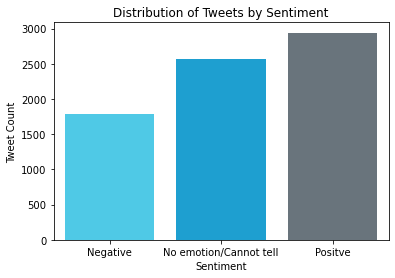

In [317]:
# # Visualizing the combined dataset (initial and synthetic texts) for Apple products only - Sentiment assigned by VADER
#############MP Note - the classes are strings here, not numeric --
fig, ax = plt.subplots()

custom_palette = ['#36d8ff', '#00acee', '#66757f']

#classes = [0, 1, 2]
classes = ["0", "1", "2"]
sns.countplot(x='emotion', data=df_combo, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion/Cannot tell', 'Positve'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('images/fig2.png', dpi=200, transparent=True)
plt.show()

In [318]:
df_combo["emotion"].value_counts()

2    2942
1    2571
0    1793
Name: emotion, dtype: int64

In [319]:
# Updating the data type to an integer
df_combo['emotion']=df_combo['emotion'].astype(np.int64)

In [320]:
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7306 entries, 0 to 1767
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      7306 non-null   object 
 1   product         7306 non-null   object 
 2   sentiment       7306 non-null   object 
 3   compound_score  7306 non-null   float64
 4   emotion         7306 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 502.5+ KB


In [321]:
# Sampling 1500 tweets from each of the three sentiment category
df_combo_neg_sample = df_combo[df_combo['emotion'] == 0].sample(n=1500)
df_combo_neutral_sample = df_combo[df_combo['emotion'] == 1].sample(n=1500)
df_combo_pos_sample = df_combo[df_combo['emotion'] == 2].sample(n=1500)

In [322]:
df_combo_neg_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 7981 to 1144
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      1500 non-null   object 
 1   product         1500 non-null   object 
 2   sentiment       1500 non-null   object 
 3   compound_score  1500 non-null   float64
 4   emotion         1500 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 70.3+ KB


In [323]:
df_combo_neutral_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 3122 to 8395
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      1500 non-null   object 
 1   product         1500 non-null   object 
 2   sentiment       1500 non-null   object 
 3   compound_score  1500 non-null   float64
 4   emotion         1500 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 70.3+ KB


In [324]:
df_combo_pos_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 5670 to 790
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      1500 non-null   object 
 1   product         1500 non-null   object 
 2   sentiment       1500 non-null   object 
 3   compound_score  1500 non-null   float64
 4   emotion         1500 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 70.3+ KB


In [325]:
# Recombining the three sentiment datasets into a single balanced dataset
df_combo_sample = pd.concat([df_combo_neg_sample, df_combo_neutral_sample, df_combo_pos_sample], axis=0)

In [326]:
df_combo_sample.head()

,tweet_text,product,sentiment,compound_score,emotion
7981,I'm obsessed with this #sxsw go iphone app. Fe...,Apple,"{'neg': 0.334, 'neu': 0.666, 'pos': 0.0, 'comp...",-0.7190,0
1487,"""Thought the iPod Touch would be a game-change...",Apple,"{'neg': 0.217, 'neu': 0.783, 'pos': 0.0, 'comp...",-0.6310,0
1443,MacBook screen glare: blinding me one frustrat...,Apple,"{'neg': 0.237, 'neu': 0.763, 'pos': 0.0, 'comp...",-0.4767,0
7839,#sxsw it's absolutely hysterical watching peop...,Apple,"{'neg': 0.165, 'neu': 0.835, 'pos': 0.0, 'comp...",-0.2446,0
935,Apple Music recommendations: because apparentl...,Apple,"{'neg': 0.141, 'neu': 0.859, 'pos': 0.0, 'comp...",-0.3182,0


In [327]:
df_combo_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 7981 to 790
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      4500 non-null   object 
 1   product         4500 non-null   object 
 2   sentiment       4500 non-null   object 
 3   compound_score  4500 non-null   float64
 4   emotion         4500 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 210.9+ KB


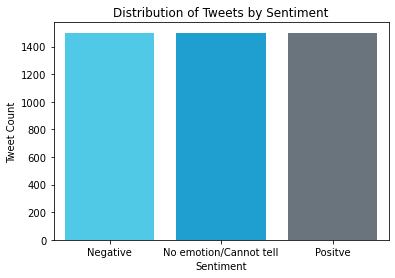

In [328]:
# Balanced distribution of sentiment for Apple products
fig, ax = plt.subplots()

classes = [0, 1, 2]

custom_palette = ['#36d8ff', '#00acee', '#66757f']
sns.countplot(x='emotion', data=df_combo_sample, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion/Cannot tell', 'Positve'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('images/fig3.png', dpi=200, transparent=True)
plt.show()

In [329]:
df_combo_sample['emotion'].value_counts(normalize=True)

2    0.333333
1    0.333333
0    0.333333
Name: emotion, dtype: float64

In [330]:
# Clean up dataset to only include tweet text and emotion
columns_to_drop = ['sentiment', 'compound_score', 'product']
df_combo_sample.drop(columns=columns_to_drop, inplace=True)

### Word Frequencies by Sentiment

This section continues data exploration. We create several Word Clouds by sentiment to visualize the most frequently appearing words. 

### Positive Sentiment

In [331]:
# Looking at the positve sentiment dataset only
df_combo_pos_sample.drop(columns=columns_to_drop, inplace=True)

In [332]:
# Defining X and y
X=df_combo_pos_sample["tweet_text"]
y=df_combo_pos_sample["emotion"]

In [333]:
sw = stopwords.words('english')

In [334]:
# Adding stopwords based on the dataset
sw.extend(["apple", "amp", "quot", "sxsw", "mention", "rt", "link", "new", "get", "line", "go", "use", "one", "via", "need", "would", "try", "come", "day", "give", "see", "know", "sxswi", "th", "even", "guy", "say"])

In [335]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [336]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [337]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X]

In [338]:
token_tweets

['deviantart buy ipad austin test muro draw super fast deviantart',
 'cnngrill celebrate piday pecan strawberry rhubarb pie let circumference begin',
 'music playlist every song emotional rollercoaster applemusicmayhem',
 'head hear talk integrate social network dynamic team synergy get ipad ready',
 'wife try call att iphone att number work take att network nationwide',
 'great night interactive party congress ave amaze store',
 'people back home seem put together pop store people ipad today',
 'something ventured great great story include genentech cisco',
 'macbook charger cable fray like try unravel mystery universe chargerissues',
 'haha awesomely rad ipad app hollergram',
 'important thing need design ipad gesture ability talk hand listen',
 'ipad underwhelming expect flagship tablet ipad letdown',
 'geek somewhere downtown ipad drop',
 'win free ipad webdoc com',
 'glad bring mac pc clearly cool environment may walk around theplatform ipad',
 'give away ipad x box book techenvy'

In [339]:
# Instantiating Count Vectorizer
cv=CountVectorizer()

In [340]:
# Fitting and transforming
X_vec_pos = cv.fit_transform(token_tweets)
X_vec_pos = pd.DataFrame.sparse.from_spmatrix(X_vec_pos)
X_vec_pos.columns = sorted(cv.vocabulary_)
X_vec_pos.set_index(y.index, inplace=True)

In [341]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X]

In [413]:
word_frequencies = X_vec_pos.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(55)

# Print the most common words and their frequencies
print(most_common_words)

           Frequency
Word                
ipad             720
iphone           448
store            231
app              187
austin           172
like             132
win              131
free             127
pop               88
letdown           86
get               84
open              81
give              67
ipod              64
music             63
design            61
great             60
android           58
cool              57
good              57
today             57
think             54
screen            54
time              51
thanks            50
well              50
love              49
launch            49
want              49
thing             48
look              47
make              46
party             44
best              44
check             43
go                42
buy               41
japan             39
away              38
case              38
macbook           37
itunes            35
awesome           35
temporary         34
keep              33
apps         

In [343]:
#!pip install wordcloud

In [344]:
#!pip install --upgrade pip

In [345]:
#!pip install --upgrade Pillow

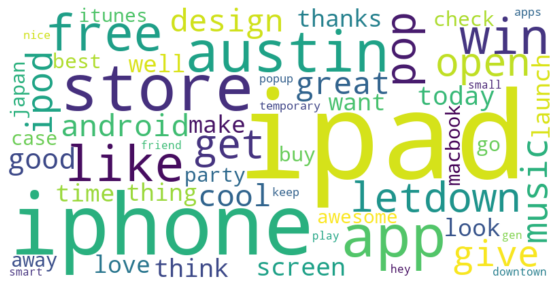

In [414]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

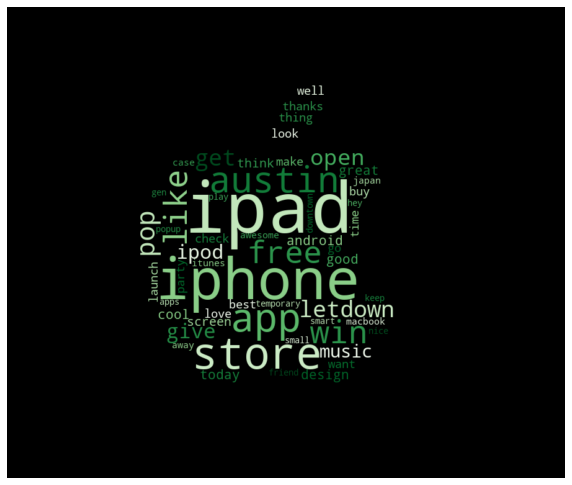

In [415]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

colormap = 'Greens'

current_dir = os.getcwd()

# Load the mask image
mask_image_path = os.path.join(current_dir, 'images', 'Apple_black_white_20240507.jpg')
mask_image = np.array(Image.open(mask_image_path))

# Generate word cloud with the mask image
wordcloud = WordCloud(mask=mask_image, background_color='black', colormap=colormap).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Negative Sentiment
(As mentioned in the limitations above, the synthetic data used to balance the dataset brought in some vocabulary repeatedly. This most likely impacted the frequency and is reflected in the Word Cloud below.) 

In [348]:
# Looking at the negative sentiment dataset only
df_combo_neg_sample.drop(columns=columns_to_drop, inplace=True)

In [349]:
# Defining X and y
X=df_combo_neg_sample["tweet_text"]
y=df_combo_neg_sample["emotion"]

In [350]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [351]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [352]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X]

In [353]:
token_tweets

['obsess iphone app feckin genius crazy long list session less scary',
 'think ipod touch game changer gimmick ipodtouch disappointed',
 'macbook screen glare blind frustration time applescreenstruggle',
 'absolutely hysterical watch people take photo w ipad',
 'music recommendation apparently music taste confuse teenager applemusicmockery',
 'try macbook heavy outdated worth investment macbook disappoint',
 'ipad battery drain faster faucet leak batterydrain',
 'film ipad much cooler lame iphone live show',
 'macbook fan louder professor lecture decide noise annoy macbooknoise',
 'wrap around block street ipad popup store',
 'saw iphone reception issue overshadow sleek design iphone disappoint',
 'miss battelle interview ipad social medium last week find video',
 'barry diller think ipad content nut mentionw',
 'macbook pro disappoints overprice underwhelming macbookpro disappoint',
 'music playlist disappear frustration appear applemusicproblems',
 'demoed iphone g painfully slow out

In [354]:
# Instantiating Count Vectorizer
cv=CountVectorizer()

In [355]:
# Fitting and transoforming
X_vec_neg = cv.fit_transform(token_tweets)
X_vec_neg = pd.DataFrame.sparse.from_spmatrix(X_vec_neg)
X_vec_neg.columns = sorted(cv.vocabulary_)
X_vec_neg.set_index(y.index, inplace=True)

In [356]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X]

In [357]:
word_frequencies = X_vec_neg.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(80)

# Print the most common words and their frequencies
print(most_common_words)

            Frequency
Word                 
iphone            555
ipad              498
disappoint        305
macbook           217
letdown           173
...               ...
camera             30
innovation         30
trouble            30
overprice          29
fail               29

[80 rows x 1 columns]


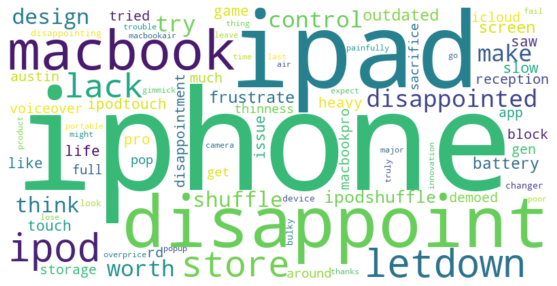

In [358]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

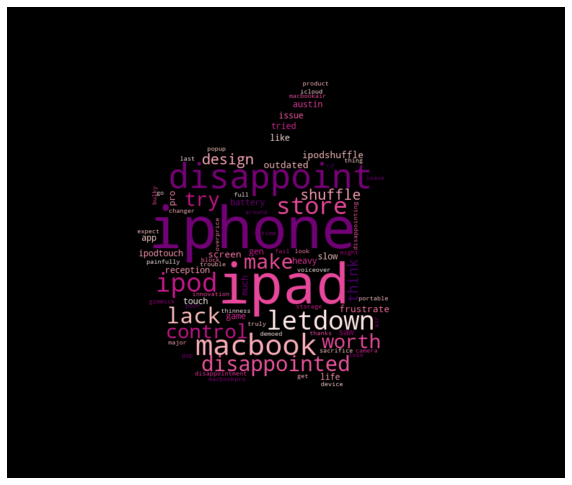

In [359]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

colormap = 'RdPu'
current_dir = os.getcwd()

# Load the mask image
mask_image_path = os.path.join(current_dir, 'images', 'Apple_black_white_20240507.jpg')
mask_image = np.array(Image.open(mask_image_path))

# Generate word cloud with the mask image
wordcloud = WordCloud(mask=mask_image, background_color='black', colormap=colormap).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Neutral Sentiment

In [360]:
# Looking at the neutral sentiment dataset only
df_combo_neutral_sample.drop(columns=columns_to_drop, inplace=True)

In [361]:
# Defining X and y
X=df_combo_neutral_sample["tweet_text"]
y=df_combo_neutral_sample["emotion"]

In [362]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [363]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [364]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X]

In [365]:
token_tweets

['session next design ipad interface navigation schema uxdes',
 'liquidspace launch iphone app mobile marketplace workspace',
 'monday adfonic daily read iphone white release google social thing mobile',
 'last fastcompanygrille last iphone makery zazzlesxsw',
 'ipad app crash often clumsy juggler ipadappcrash',
 'ipad live unboxing front store video',
 'platformer ci di venue pake app sq api cnth tweetdeck etc iphone android ipad pc',
 'wonder many ipad sell',
 'turn ipad physical messaging platform holler gram cheeky app build',
 'pop store finally dwindle time check ipad',
 'come cool technology ever hear conference',
 'spilled bean next platform flipboard iphone team start work sxflip',
 'wait store open open day ipad sale null',
 'ipad apps speech therapy communication showcased conference apraxia speed',
 'rumor open temporary store dt atx ipad launch',
 'ipad come buy open store near ipad release',
 'siri think speak tongue ask direction siriconfusion',
 'heard open store downto

In [366]:
# Instantiating Count Vectorizer
cv=CountVectorizer()

In [367]:
# Fitting and Transforming
X_vec_neutral = cv.fit_transform(token_tweets)
X_vec_neutral = pd.DataFrame.sparse.from_spmatrix(X_vec_neutral)
X_vec_neutral.columns = sorted(cv.vocabulary_)
X_vec_neutral.set_index(y.index, inplace=True)

In [368]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X]

In [369]:
word_frequencies = X_vec_neutral.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(80)

# Print the most common words and their frequencies
print(most_common_words)

        Frequency
Word             
ipad          733
store         523
iphone        356
austin        241
pop           227
...           ...
case           22
pic            22
use            21
siri           20
start          20

[80 rows x 1 columns]


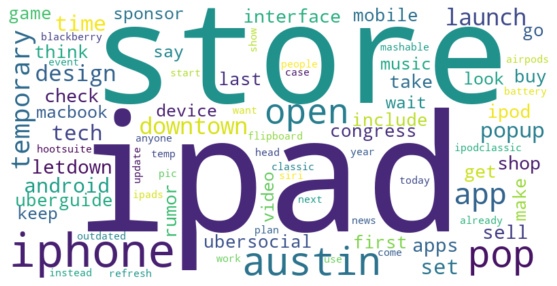

In [370]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

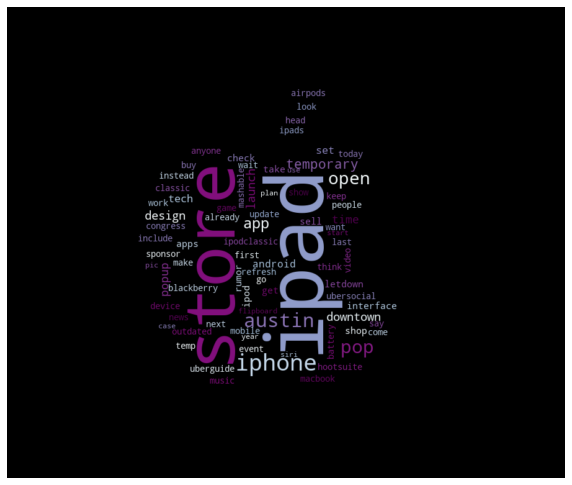

In [371]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

colormap = 'BuPu'
current_dir = os.getcwd()

# Load the mask image
mask_image_path = os.path.join(current_dir, 'images', 'Apple_black_white_20240507.jpg')
mask_image = np.array(Image.open(mask_image_path))

# Generate word cloud with the mask image
wordcloud = WordCloud(mask=mask_image, background_color='black', colormap=colormap).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Train Test Split for Modeling and Pre Processing

Our inital dataset at the beginning of this notebook reviewed tweets manually by people and were assigned sentiment based on their interpretation. While we find that this is possibly the most accurate and precise method it is not a practical model for large data. Below we begin looking at  models to determine the best methods to predict sentiment of tweets about about Apple products.

In [372]:
# Defining X and y
X=df_combo_sample["tweet_text"]
y=df_combo_sample["emotion"]

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2)

In [374]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [375]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [376]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X_train]

In [377]:
token_tweets

['open temporary store congress tomorrow march ipad sale miss',
 'life much well ipad brainwash line',
 'airpods need wire constant connection issue instead wirelesswoes',
 'ipod nano generation disappointment sure small lack physical control make frustrate clip design impractical ipodnano disappointing',
 'ten percent crowd design ipad interface already ipad',
 'tried ipod shuffle rd gen voiceover control gimmick ipodshuffle disappoint',
 'saw iphone reception issue major setback iphone disappoint',
 'think ipod touch versatile glorified music player ipodtouch letdown',
 'lovely iphone app thanks awesome integration',
 'coolest ipad case ever etch sketch',
 'hmmmm oppty ipad stop tempting',
 'ipad dj tuesday douche bag apply',
 'barry diller think ipad content nut mentionw',
 'damn know like begin win',
 'mashable talk taker many spend good part ipad gadget',
 'session kawasaki former chief evangelist',
 'music playlist like misery mixtape musicfail',
 'demoed iphone g painfully slow 

We are beginnng with a Count Vectorizer because we are most interested in overall counts and less concerned about weighting words that are unique throughout the entire dataset.

In [378]:
X_train.head()

4029    Apple will be opening a temporary Apple Store ...
7206    My life would be so much better with an iPad. ...
1408    AirPods: because who needs wires when you can ...
855     "The iPod Nano 6th Generation was a disappoint...
4742    Ten percent of the crowd at &quot;Designing iP...
Name: tweet_text, dtype: object

In [379]:
# Instantiating Count Vectorizer
cv=CountVectorizer()

In [380]:
# Fitting and transforming the X_train
X_train_vec = cv.fit_transform(token_tweets)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [381]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X_test]

In [382]:
# Transforming the X_test
X_test_vec = cv.transform(token_tweets_test)
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)

In [383]:
X_train_vec.head()

,aapl,aaron,aarpbulletin,ab,abacus,abc,aber,ability,able,abnormal,...,zen,zeus,zimride,zinio,zms,zomg,zone,zuckerberg,zynga,zzzs
4029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Model 1. We started with a Multinomial Naive Bayes (MNB) model on the Count Vectorized data. MNB is efficient and speedy with large datasets and a good test classifier.

In [384]:
# Instantiating a Multinomial Naive Bayes model
mnb = MultinomialNB()

In [385]:
# Fitting the vectorized X and y train data to the model
mnb.fit(X_train_vec, y_train)

MultinomialNB()

In [386]:
# Predicting the y from the vectorized X_test data
y_pred=mnb.predict(X_test_vec)

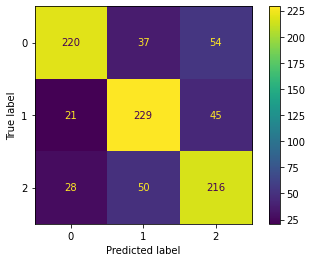

In [387]:
# Create and plot a confusion matrix to evaluate model performance
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(mnb, X_test_vec, y_test );

In [388]:
# Additional model evaluation
accuracy_score(y_test, y_pred)

0.7388888888888889

In [389]:
# Additional model evaluation
precision_score(y_test, y_pred, average='weighted')

0.7441456532764471

In [390]:
# Additional model evaluation
recall_score(y_test, y_pred, average='weighted')

0.7388888888888889

In [391]:
# Determine the most common words in the dataset
word_frequencies = X_train_vec.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(30)

# Print the most common words and their frequencies
print(most_common_words)

              Frequency
Word                   
ipad               1543
iphone             1094
store               730
austin              375
app                 315
pop                 288
disappoint          242
open                238
letdown             235
ipod                224
macbook             220
design              183
like                160
make                153
think               147
get                 128
temporary           122
time                119
win                 118
screen              116
free                113
launch              111
battery             105
popup               104
game                103
disappointed        101
android             101
lack                100
downtown             99
look                 96


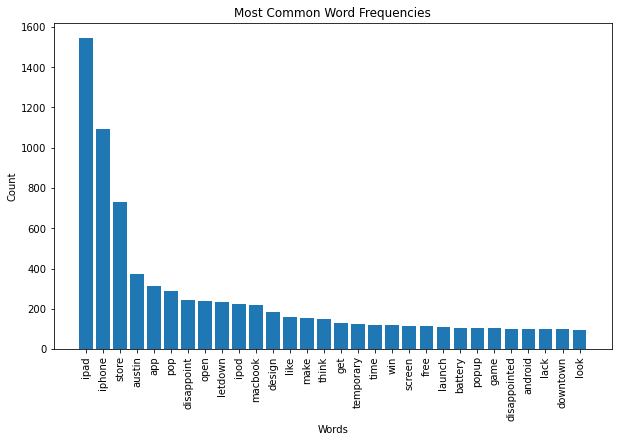

In [392]:
# Visaulize the most common words
most_common_words = word_frequencies_df.head(30)
words = most_common_words.index
counts = most_common_words['Frequency']

plt.figure(figsize=(10, 6))
plt.bar(range(len(words)), counts, tick_label=words)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Most Common Word Frequencies')
plt.xticks(rotation=90)
plt.show()

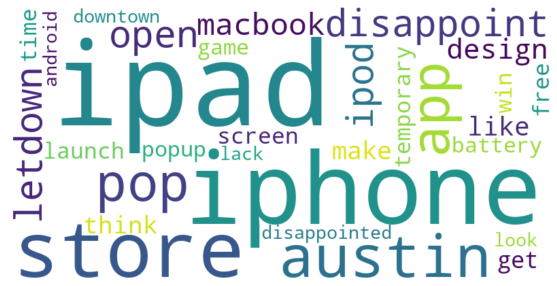

In [393]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We explored a TF-IDF Vectorizer to look at the impact of weighting more unique words across the dataset.  

In [394]:
# Instantiating the TF-IDF Vectorizer
tfidf = TfidfVectorizer()

In [395]:
# Fitting and transforming the X_train
X_train_vec_tfidf = tfidf.fit_transform(token_tweets)
X_train_vec_tfidf = pd.DataFrame.sparse.from_spmatrix(X_train_vec_tfidf)
X_train_vec_tfidf.columns = sorted(tfidf.vocabulary_)
X_train_vec_tfidf.set_index(y_train.index, inplace=True)

In [396]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X_test]

In [397]:
# Transforming the X_test
X_test_vec_tfidf = tfidf.transform(token_tweets_test)
X_test_vec_tfidf = pd.DataFrame.sparse.from_spmatrix(X_test_vec_tfidf)
X_test_vec_tfidf.columns = sorted(tfidf.vocabulary_)
X_test_vec_tfidf.set_index(y_test.index, inplace=True)

In [398]:
X_train_vec_tfidf.head()

,aapl,aaron,aarpbulletin,ab,abacus,abc,aber,ability,able,abnormal,...,zen,zeus,zimride,zinio,zms,zomg,zone,zuckerberg,zynga,zzzs
4029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Model 2. We next ran another MNB model, but this time on the TF_IDF Vectorized data. MNB is efficient and speedy with large datasets and a good test classifier.

In [399]:
# Instantiating a Multinomial Naive Bayes model
mnb2 = MultinomialNB()

In [400]:
# Fitting the vectorized X and y train data to the model
mnb2.fit(X_train_vec_tfidf, y_train)

MultinomialNB()

In [401]:
# Predicting the y from the vectorized X_test data
y_pred2=mnb2.predict(X_test_vec_tfidf)

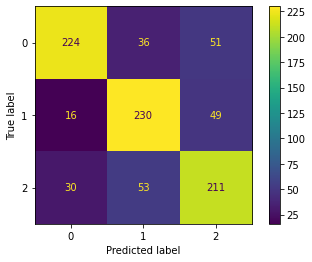

In [402]:
# Create and plot a confusion matrix to evaluate model performance
cm2 = confusion_matrix(y_test, y_pred2)
plot_confusion_matrix(mnb2, X_test_vec_tfidf, y_test );

In [403]:
# Additional model evaluation
accuracy_score(y_test, y_pred2)

0.7388888888888889

In [404]:
# Additional model evaluation
precision_score(y_test, y_pred2, average='weighted')

0.7446410861353636

In [405]:
# Additional model evaluation
recall_score(y_test, y_pred2, average='weighted')

0.7388888888888889

In [406]:
# Assuming X_train_vec is your vectorized dataset (e.g., using CountVectorizer)
word_frequencies_tfidf = X_train_vec_tfidf.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df2 = pd.DataFrame(word_frequencies_tfidf, columns=['Frequency'])
word_frequencies_df2.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df2 = word_frequencies_df2.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words2 = word_frequencies_df2.head(30)

# Print the most common words and their frequencies
print(most_common_words2)

               Frequency
Word                    
ipad          196.804186
iphone        153.925210
store         146.498420
austin         87.473627
pop            80.484946
open           70.113822
app            64.301974
disappoint     57.789286
letdown        56.263895
macbook        54.229192
ipod           53.792184
design         44.169796
temporary      43.063304
think          39.642835
win            37.013810
make           36.719572
like           36.598921
launch         34.752569
downtown       34.537224
popup          32.593386
get            32.486020
time           31.986596
disappointed   31.270871
screen         30.621701
free           29.080372
game           28.362248
outdated       27.966404
control        27.763005
try            27.261946
touch          27.032062


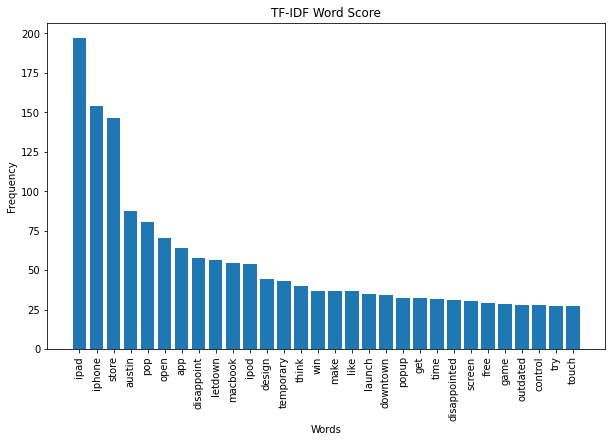

In [407]:
# Extract words and their counts from most_common_words DataFrame
most_common_words2= word_frequencies_df2.head(30)
words = most_common_words2.index
counts = most_common_words2['Frequency']

plt.figure(figsize=(10, 6))
plt.bar(range(len(words)), counts, tick_label=words)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('TF-IDF Word Score')
plt.xticks(rotation=90)
plt.show()

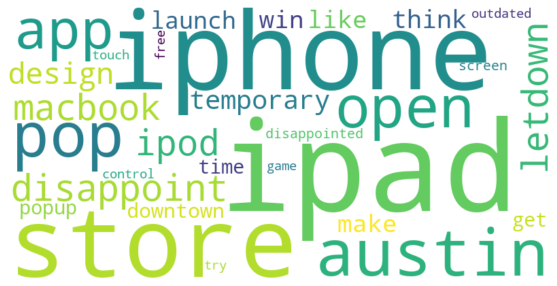

In [408]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words2['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Before running a Random Forest Classifier we created a grid search to look for the best parameters for the model.

In [409]:
# Creating a grid search to find the best hyperparameters to include in the model
grid = {'n_estimators': [500, 1000, 1500],
       'max_depth': [8, 10, 12, 14],
        'max_features': [3, 6, 9]
                }

In [410]:
# Instantiating a random forest classifier
rf_clf = RandomForestClassifier(random_state=42)

In [411]:
#grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid, cv=5, scoring='accuracy')
#grid_search.fit(X_train_vec, y_train)

In [412]:
grid_search.best_params_

NameError: name 'grid_search' is not defined

In [ ]:
grid_search.best_score_

Model 3. In this model we ran a Random Forest Classifer (RFC), using the Count Vectorized data again. 

In [ ]:
# Running the Random Forest Classifier with the best parameters from the grid search; using the count vectorized data
rf = RandomForestClassifier(n_estimators=1000, max_features=9, max_depth=14, random_state=42)
rf.fit(X_train_vec, y_train)
y_pred = rf.predict(X_test_vec)
precision_score(y_test, y_pred, average="weighted")

In [ ]:
#grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid, cv=5, scoring='accuracy')
#grid_search.fit(X_train_vec_tfidf, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

Model 4. In this model we ran a RFC again, but this time using the TF-IDF Vectorized data again. 

In [ ]:
# Running the Random Forest Classifier with the best parameters from the grid search; using the TF-IDF vectorized data
rf = RandomForestClassifier(n_estimators=1500, max_features=3, max_depth=14, random_state=42)
rf.fit(X_train_vec_tfidf, y_train)
y_pred = rf.predict(X_test_vec_tfidf)
precision_score(y_test, y_pred2, average="weighted")

The Count Vectorized Random Forest Classifier (Model 3) has the highest ______ score. Interpret HERE. 

Monica's notes to self

- were there duplicates in the original dataset?
